In [1]:
import math
import itertools
import collections
import re
import os

import tqdm
import numpy as np
import pandas as pd
import scipy

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

import sklearn
from sklearn import ensemble
from sklearn import pipeline
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, f1_score
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics.pairwise import cosine_similarity
import patsy

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
#import statannot
import statannotations
from statannotations.Annotator import Annotator
from statannotations.stats.StatTest import StatTest
import plotnine as p9

import Bio.motifs as motifs

In [2]:
# paths 
import os

# To change the directory
#os.chdir('/s/project/semi_supervised_multispecies/Zenodo/zenodo/')
os.chdir("/data/nasif12/home_if12/huan/monarch")
# To check the current working directory
print(os.getcwd())



project_path = "./embeddings_outputs/."
#project_path = "."

/data/ceph/hdd/project/node_09/semi_supervised_multispecies/monarch


# Utility Functions

In [3]:
class Kmerizer:
    
    def __init__(self, k, overlap=True, log=False, divide=False, leave_one_out=False):
        self.k = k
        if leave_one_out:
            self.kmers = {"".join(x):i for i,x in zip(range(4**k), [x for x in itertools.product("ACGT",repeat=k)][:-1])}
        else:
            self.kmers = {"".join(x):i for i,x in zip(range(4**k), itertools.product("ACGT",repeat=k))}
        self.log = log
        self.divide = divide
        self.overlap = overlap
        
    def kmerize(self, seq):
        counts = np.zeros(4**self.k)
        i = 0
        jump = 1 if self.overlap else self.k
        while i < len(seq) - self.k + 1: 
            kmer = seq[i:i+self.k]
            if "N" in kmer:
                i += jump
                continue
            counts[self.kmers[kmer]] += 1
            i += jump
        if self.divide:
            counts = counts/len(seq)
        if self.log:
            counts = np.log(counts + 1)
        return counts
    
    def tokenize(self, seq, jump=False):
        kmers = []
        i = 0
        while i < len(seq) - self.k + 1: 
            kmer = seq[i:i+self.k]
            kmers.append(kmer)
            if jump:
                i += self.k
            else:
                i += 1
        return kmers
    
kmerizer2 = Kmerizer(k=2)
kmerizer3 = Kmerizer(k=3)
kmerizer4 = Kmerizer(k=4)
kmerizer5 = Kmerizer(k=5)
kmerizer6 = Kmerizer(k=6)
kmerizer7 = Kmerizer(k=7)

codonmerizer = Kmerizer(k=3,overlap=False, log=True, divide=True)

In [4]:
def pearson_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    if len(y_pred.shape) == 2:
        y_pred = y_pred.reshape(-1)
    return scipy.stats.pearsonr(y, y_pred)[0]

def pearson_r2(estimator, X, y):
    y_pred = estimator.predict(X)
    #print(estimator[1].alpha_)
    if len(y_pred.shape) == 2:
        y_pred = y_pred.reshape(-1)
    return scipy.stats.pearsonr(y, y_pred)[0] ** 2

def pearson_r2_metric(y_true, y_pred):
    return scipy.stats.pearsonr(y_true, y_pred)[0] ** 2

def spearman_metric(y_true, y_pred):
    return scipy.stats.spearmanr(y_true, y_pred)[0]

In [5]:
import os
def extract_model_and_dataset_from_directory(dir_path):
    dataset_and_model_map = dict()
    for folder in os.listdir(dir_path):
        try:
            model_type, dataset = folder.split('-')
        except:
            continue
        if not dataset in dataset_and_model_map.keys():
            dataset_and_model_map[dataset] = [folder]
        else:
            dataset_and_model_map[dataset].append(folder)
    return dataset_and_model_map

In [6]:
dataset_and_model_map = extract_model_and_dataset_from_directory("./embeddings_outputs")

In [7]:
dataset_and_model_map

{'segal': ['m2_agnostic-segal',
  'm2_species100k_candidatoken-segal',
  'm2_species200k_candidatoken-segal',
  'vanilla_species_candidatoken-segal',
  'vanilla_agnostic-segal'],
 'scer': ['vanilla_species_candidatoken-scer',
  'vanilla_agnostic-scer',
  'm2_agnostic-scer',
  'm2_species100k-scer',
  'm2_species200k-scer'],
 'pombe': ['vanilla_agnostic-pombe',
  'm2_species100k-pombe',
  'vanilla_species_pombetoken-pombe',
  'vanilla_species_candidatoken-pombe',
  'm2_agnostic-pombe',
  'm2_species200k-pombe']}

In [28]:
def get_model_name(path):
    model_name  = path.split("-")[0]
    print(model_name)
    return (model_name)

In [9]:
import pprint
pp = pprint.PrettyPrinter(depth=4)
pp.pprint(dataset_and_model_map)

{'pombe': ['vanilla_agnostic-pombe',
           'm2_species100k-pombe',
           'vanilla_species_pombetoken-pombe',
           'vanilla_species_candidatoken-pombe',
           'm2_agnostic-pombe',
           'm2_species200k-pombe'],
 'scer': ['vanilla_species_candidatoken-scer',
          'vanilla_agnostic-scer',
          'm2_agnostic-scer',
          'm2_species100k-scer',
          'm2_species200k-scer'],
 'segal': ['m2_agnostic-segal',
           'm2_species100k_candidatoken-segal',
           'm2_species200k_candidatoken-segal',
           'vanilla_species_candidatoken-segal',
           'vanilla_agnostic-segal']}


In [10]:
get_model_name('m2_species100k-pombe')

m2_species100k


'm2_species100k'

# S. cerevisiae Half Life

## Prepare data

In [11]:
def scer_half_life(path_list):
    #Data Prep
    halflife_df = pd.read_csv("./data/Downstream_Targets/Scer_half_life.csv")
    codon_vars = ['TTC','TTA', 'TTG', 'TCT', 'TCC', 'TCA', 'TCG', 'TAT', 'TAC', 'TGT', 'TGC',
       'TGG', 'CTT', 'CTC', 'CTA', 'CTG', 'CCT', 'CCC', 'CCA', 'CCG', 'CAT',
       'CAC', 'CAA', 'CAG', 'CGT', 'CGC', 'CGA', 'CGG', 'ATT', 'ATC', 'ATA',
       'ATG', 'ACT', 'ACC', 'ACA', 'ACG', 'AAT', 'AAC', 'AAA', 'AAG', 'AGT',
       'AGC', 'AGA', 'AGG', 'GTT', 'GTC', 'GTA', 'GTG', 'GCT', 'GCC', 'GCA',
       'GCG', 'GAT', 'GAC', 'GAA', 'GAG', 'GGT', 'GGC', 'GGA', 'GGG', 'TTT']
    signif_vars = ["UTR5_length_log","GC_content_UTR5","CDS_deltaG","num_uAUG","UTR3_length_log","TGTAAATA","TGCAT","ATATTC","TTTTTTA"]
    # recompute GC content
    halflife_df['GC_content_UTR5'] = (halflife_df['UTR5_seq'].str.count('G') + halflife_df['UTR5_seq'].str.count('C'))/halflife_df['UTR5_seq'].str.len()
    halflife_df['GC_content_UTR3'] = (halflife_df['UTR3_seq'].str.count('G') + halflife_df['UTR3_seq'].str.count('C'))/halflife_df['UTR3_seq'].str.len()
    halflife_df['GC_content_CDS'] = (halflife_df['CDS_seq'].str.count('G') + halflife_df['CDS_seq'].str.count('C'))/halflife_df['CDS_seq'].str.len()
    # make uAUG an indicator
    halflife_df['num_uAUG'] = halflife_df['num_uAUG'] > 0
    # make codons into ratios
    for codon in codon_vars[:-1]:
        halflife_df[codon] = halflife_df[codon]/halflife_df['CDS_length']
    # finally log the length
    halflife_df['UTR5_length_log'] = np.log2(halflife_df['UTR5_length'])
    halflife_df['UTR3_length_log'] = np.log2(halflife_df['UTR3_length'])
    halflife_df['CDS_length_log'] = np.log2(halflife_df['CDS_length'])
    halflife_df["log_hl"] = np.log2(halflife_df["hlt.wt"])
    three_sequences = pd.read_parquet("./data/Sequences/Annotation/Sequences/saccharomyces_cerevisiae/saccharomyces_cerevisiae_three_prime.parquet")
    
    scer_emb_dict = {} 
    for path in path_list:
        tmp = np.load(f"{project_path}/{path}/embeddings.npy")            
        scer_emb_dict[get_model_name(path)] = [tmp[i] for i in range(tmp.shape[0])]
    
    for model_name, emb in scer_emb_dict.items():
        three_sequences[model_name] = emb
    three_sequences.drop_duplicates(subset=['gene_id'], keep='first', inplace=True)

    halflife_df = halflife_df.merge(three_sequences.rename(columns={"gene_id":"genename"}),on="genename")
   
    y_obs = np.array(halflife_df["log_hl"])

    X_base = np.array(halflife_df[codon_vars[:-1] + signif_vars[:-4]])

    X_jun = np.array(halflife_df[codon_vars[:-1] + signif_vars])
    
    X_models = {}
    for model in scer_emb_dict.keys():
        X_models[model] = np.concatenate([X_base, np.stack(halflife_df[model])],axis=1)
        
    X_gc = np.array(halflife_df[codon_vars[:-1] + signif_vars[:-4] + ['GC_content_UTR3']])
    X_2mer = np.concatenate([X_base, np.stack(halflife_df['UTR3_seq'].apply(lambda x: kmerizer2.kmerize(x)))],axis=1)
    X_3mer = np.concatenate([X_base, np.stack(halflife_df['UTR3_seq'].apply(lambda x: kmerizer3.kmerize(x)))],axis=1)
    X_4mer = np.concatenate([X_base, np.stack(halflife_df['UTR3_seq'].apply(lambda x: kmerizer4.kmerize(x)))],axis=1)
    X_5mer = np.concatenate([X_base, np.stack(halflife_df['UTR3_seq'].apply(lambda x: kmerizer5.kmerize(x)))],axis=1)
    X_6mer = np.concatenate([X_base, np.stack(halflife_df['UTR3_seq'].apply(lambda x: kmerizer6.kmerize(x)))],axis=1)
    
    #Predict Half Life
    
    data_matrices = {
                 "2-mer counts":X_2mer, 
                 "3-mer counts":X_3mer, 
                 "4-mer counts":X_4mer,
                 "5-mer counts":X_5mer, 
                 "Cheng Features":X_jun}
    data_matrices.update(X_models)

    rows = []
    test_predictions = []
    total_len = X_base.shape[0]
    n_splits = 10

    kfold = sklearn.model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for key in data_matrices:
        print(key)
        y = y_obs
        X = data_matrices[key]

        y_pred_list = []
        y_true_list = []
        for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
            pipe = pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.linear_model.RidgeCV(cv=5, alphas=[0.1, 1, 10, 100, 1000,10000]))
            X_train = X[train_index]
            y_train = y[train_index]
            X_test = X[test_index]
            y_test = y[test_index]
            pipe.fit(X_train,y_train)
            y_pred = pipe.predict(X_test)
            r2_test = pearson_r2_metric(y_test, y_pred)
            # save results
            y_pred_list.append(y_pred)
            y_true_list.append(y_test)
            rows.append({"model":key, "r2":r2_test})
        test_predictions.append(pd.DataFrame({"model":key, 
                                 "pred": np.concatenate(y_pred_list), 
                                 "true": np.concatenate(y_true_list)}))

    metrics_scer = pd.DataFrame(rows)
    pred_scer = pd.concat(test_predictions)
    pred_scer["residual"] = (pred_scer["true"] - pred_scer["pred"])**2
    display(metrics_scer.groupby('model').median())

    return metrics_scer, pred_scer
    
metrics_scer, pred_scer = scer_half_life(dataset_and_model_map["scer"])

vanilla_agnostic
m2_agnostic
m2_species100k
m2_species200k
2-mer counts
3-mer counts
4-mer counts
5-mer counts
Cheng Features
vanilla_agnostic
m2_agnostic
m2_species100k
m2_species200k


,r2
model,
2-mer counts,0.577900
3-mer counts,0.580361
4-mer counts,0.569335
5-mer counts,0.532131
Cheng Features,0.586421
m2_agnostic,0.582229
m2_species100k,0.585568
m2_species200k,0.577675
vanilla_agnostic,0.578150


In [35]:
display(metrics_scer.groupby('model').median())
pred_scer.to_csv("
#print(scipy.stats.wilcoxon(pred_scer.query('model == "Aware:candida glabrata"')["residual"], pred_scer.query('model == "Agnostic"')["residual"]))
#print(scipy.stats.wilcoxon(pred_scer.query('model == "Aware:candida glabrata"')["residual"], pred_scer.query('model == "Cheng Features"')["residual"]))

,r2
model,
2-mer counts,0.577900
3-mer counts,0.580361
4-mer counts,0.569335
5-mer counts,0.532131
Cheng Features,0.586421
m2_agnostic,0.588919
m2_species100k,0.585738
m2_species200k,0.585738
vanilla_agnostic,0.581174


AttributeError: module 'pandas' has no attribute 'save'

# S. pombe Half Life

In [13]:
def pombe_half_life(path_list):
    #Prepare data
    halflife_pombe_df = pd.read_csv("./data/Downstream_Targets/Pombe_half_life.csv")
    codon_vars_pombe = ['TTC','TTA', 'TTG', 'TCT', 'TCC', 'TCA', 'TCG', 'TAT', 'TAC', 'TGT', 'TGC',
       'TGG', 'CTT', 'CTC', 'CTA', 'CTG', 'CCT', 'CCC', 'CCA', 'CCG', 'CAT',
       'CAC', 'CAA', 'CAG', 'CGT', 'CGC', 'CGA', 'CGG', 'ATT', 'ATC', 'ATA',
       'ATG', 'ACT', 'ACC', 'ACA', 'ACG', 'AAT', 'AAC', 'AAA', 'AAG', 'AGT',
       'AGC', 'AGA', 'AGG', 'GTT', 'GTC', 'GTA', 'GTG', 'GCT', 'GCC', 'GCA',
       'GCG', 'GAT', 'GAC', 'GAA', 'GAG', 'GGT', 'GGC', 'GGA', 'GGG', 'TTT']

    signif_vars_pombe = ['UTR3_length_log','UTR5_length_log','CDS_length_log',
               "stopPlus1",
               "num_uAUG","CAACCA","ACCAAC",
               "GC_content_UTR5","UTR5_deltaG","CDS_deltaG","GC_content_CDS",
               "UTR3_deltaG","GC_content_UTR3","TATTTAT","TTAATGA","ACTAAT"]
    # recompute GC content
    halflife_pombe_df['GC_content_UTR5'] = (halflife_pombe_df['UTR5_seq'].str.count('G') + halflife_pombe_df['UTR5_seq'].str.count('C'))/halflife_pombe_df['UTR5_seq'].str.len()
    halflife_pombe_df['GC_content_UTR3'] = (halflife_pombe_df['UTR3_seq'].str.count('G') + halflife_pombe_df['UTR3_seq'].str.count('C'))/halflife_pombe_df['UTR3_seq'].str.len()
    #halflife_pombe_df['GC_content_CDS'] = (halflife_pombe_df['CDS_seq'].str.count('G') + halflife_pombe_df['CDS_seq'].str.count('C'))/halflife_pombe_df['CDS_seq'].str.len()
    # make uAUG an indicator
    halflife_pombe_df['num_uAUG'] = halflife_pombe_df['num_uAUG'] > 0
    # make codons into ratios
    for codon in codon_vars_pombe[:-1]:
        halflife_pombe_df[codon] = halflife_pombe_df[codon]/halflife_pombe_df['CDS_length']
    # finally log the length
    halflife_pombe_df['UTR5_length_log'] = np.log2(halflife_pombe_df['UTR5.length'])
    halflife_pombe_df['UTR3_length_log'] = np.log2(halflife_pombe_df['UTR3.length'])
    halflife_pombe_df['CDS_length_log'] = np.log2(halflife_pombe_df['CDS_length'])
    halflife_pombe_df["log_hl"] = np.log2(halflife_pombe_df["half.life"])
    ols_hl_pombe_full = (statsmodels.regression.linear_model.OLS
                  .from_formula('log_hl ~ {}'.format("+".join(codon_vars_pombe + signif_vars_pombe)),
                                data=halflife_pombe_df))#.query('UTR5_length >= 20 and UTR3_length >= 20')))

    res_hl_pombe_full = ols_hl_pombe_full.fit()
    
    three_sequences = pd.read_csv("./data/Sequences/Annotation/Sequences/schizosaccharomyces_pombe/schizosaccharomyces_pombe_three_prime_remapped.tsv",sep="\t")
    
    pombe_emb_dict = {} 
    for path in path_list:
        tmp = np.load(f"{project_path}/{path}/embeddings.npy")            
        pombe_emb_dict[get_model_name(path)] = [tmp[i] for i in range(tmp.shape[0])]
    
    for model_name, emb in pombe_emb_dict.items():
        three_sequences[model_name] = emb
    three_sequences.drop_duplicates(subset=['gene_id'], keep='first', inplace=True)


    halflife_pombe_df = halflife_pombe_df.merge(three_sequences[["map.ids"] +list(pombe_emb_dict.keys())],on="map.ids")
    y_obs = np.array(halflife_pombe_df["log_hl"])

    X_base = np.asarray(patsy.dmatrix('~ -1 + {}'.format("+".join(codon_vars_pombe[:-1] + signif_vars_pombe[:-5])), 
                  data=halflife_pombe_df))

    X_jun = np.concatenate([X_base, np.array(halflife_pombe_df[signif_vars_pombe[-5:]])],axis=1)
    #X_emb = np.concatenate([X_base, emb_pombe],axis=1)
    X_gc = np.concatenate([X_base, np.array(halflife_pombe_df[['GC_content_UTR3']])],axis=1)
    
    X_models = {}
    for model in pombe_emb_dict.keys():
        X_models[model] = np.concatenate([X_base, np.stack(halflife_pombe_df[model])],axis=1)

    X_2mer = np.concatenate([X_base, np.stack(halflife_pombe_df['UTR3_seq'].apply(lambda x: kmerizer2.kmerize(x)))],axis=1)
    X_3mer = np.concatenate([X_base, np.stack(halflife_pombe_df['UTR3_seq'].apply(lambda x: kmerizer3.kmerize(x)))],axis=1)
    X_4mer = np.concatenate([X_base, np.stack(halflife_pombe_df['UTR3_seq'].apply(lambda x: kmerizer4.kmerize(x)))],axis=1)
    X_5mer = np.concatenate([X_base, np.stack(halflife_pombe_df['UTR3_seq'].apply(lambda x: kmerizer5.kmerize(x)))],axis=1)
    X_6mer = np.concatenate([X_base, np.stack(halflife_pombe_df['UTR3_seq'].apply(lambda x: kmerizer6.kmerize(x)))],axis=1)
    
    #Pred Half Life
    
    data_matrices = {"2-mer counts":X_2mer, 
                 "3-mer counts":X_3mer, 
                 "4-mer counts":X_4mer,
                 "5-mer counts":X_5mer, 
                 "Eser Features":X_jun}
    data_matrices.update(X_models)
    rows = []
    test_predictions = []
    total_len = X_base.shape[0]
    n_splits = 10

    kfold = sklearn.model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for key in data_matrices:
        print(key)
        y = y_obs
        X = data_matrices[key]

        y_pred_list = []
        y_true_list = []
        for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
            pipe = pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.linear_model.RidgeCV(cv=5, alphas=[0.1, 1, 10, 100, 1000,10000]))
            X_train = X[train_index]
            y_train = y[train_index]
            X_test = X[test_index]
            y_test = y[test_index]
            pipe.fit(X_train,y_train)
            y_pred = pipe.predict(X_test)
            r2_test = pearson_r2_metric(y_test, y_pred)
            # save results
            y_pred_list.append(y_pred)
            y_true_list.append(y_test)
            rows.append({"model":key, "r2":r2_test})
        test_predictions.append(pd.DataFrame({"model":key, 
                                 "pred": np.concatenate(y_pred_list), 
                                 "true": np.concatenate(y_true_list)}))

    metrics_pombe = pd.DataFrame(rows)
    pred_pombe = pd.concat(test_predictions)
    pred_pombe["residual"] = (pred_pombe["true"] - pred_pombe["pred"])**2
    display(metrics_pombe.groupby('model').agg("median"))
    return metrics_pombe, pred_pombe

In [14]:
metrics_pombe, pred_pombe = pombe_half_life(dataset_and_model_map["pombe"])

vanilla_agnostic
m2_species100k
vanilla_species_pombetoken
vanilla_species_candidatoken
m2_agnostic
m2_species200k
2-mer counts
3-mer counts
4-mer counts
5-mer counts
Eser Features
vanilla_agnostic
m2_species100k
vanilla_species_pombetoken
vanilla_species_candidatoken
m2_agnostic
m2_species200k


,r2
model,
2-mer counts,0.421239
3-mer counts,0.432528
4-mer counts,0.450010
5-mer counts,0.400181
Eser Features,0.434660
m2_agnostic,0.482896
m2_species100k,0.464989
m2_species200k,0.464214
vanilla_agnostic,0.478913


In [30]:
scipy.stats.wilcoxon(pred_pombe.query('model == "Aware:schizosaccharomyces pombe"')["residual"], pred_pombe.query('model == "Eser Features"')["residual"])

WilcoxonResult(statistic=2949429.0, pvalue=2.055200150281855e-13)

# 3' UTR MPRA

In [11]:
def segal_mpra(path_list):
    mpra_df = pd.read_csv("./data/Downstream_Targets/segal_2015.tsv",sep="\t").dropna().reset_index(drop=True).reset_index()

    mpra_df['TGTAAATA'] = mpra_df['Oligo Sequence'].str.count('TGTAAATA')
    mpra_df['TGCAT'] = mpra_df['Oligo Sequence'].str.count('TGCAT')
    mpra_df['ATATTC'] = mpra_df['Oligo Sequence'].str.count('ATATTC')
    mpra_df['TTTTTTA'] = mpra_df['Oligo Sequence'].str.count('TTTTTTA')
    mpra_df['GC_content_UTR3'] = (mpra_df['Oligo Sequence'].str.count('G') + mpra_df['Oligo Sequence'].str.count('C'))/mpra_df['Oligo Sequence'].str.len()

    def replacer(x):
        x = (x.replace("native_","")
                .replace("pad_","")
                .replace("Lib_pre_","")
                .replace("term_full_","")
                .replace("term_null_","")
                .replace("term_ins_","")
                .replace("lib_suff_nag_","")
                .replace("ib_suff_osz_","")
                .replace("stop_codon_","")
                .replace("canon_term_neg_","")
                .replace("canon_term_pos_","")
                .replace("_no_ins","")
                .replace("_three_ins","")
                .replace("_four_ins","")
                .replace("_two_ins","")
                .replace("_one_ins","")
                .replace("_one","")
                .replace("_synth_insert_pad","")
                .replace("_synth_t","")
                .replace("_512_mut","")
                .replace("_wt","")
               )
        if x.startswith('l'):
            return x[1:]
        else:
            return x

    mpra_df['block'] = [replacer(x.split("#")[1].split("context_")[-1]) for x in mpra_df["Description"]]

    y_obs = np.array(np.log2(mpra_df["Expression"]))
    groups = np.array(mpra_df['block'])

    X_2mer = np.stack(mpra_df['Oligo Sequence'].apply(lambda x: kmerizer2.kmerize(x)))
    X_3mer = np.stack(mpra_df['Oligo Sequence'].apply(lambda x: kmerizer3.kmerize(x)))
    X_4mer = np.stack(mpra_df['Oligo Sequence'].apply(lambda x: kmerizer4.kmerize(x)))
    X_5mer = np.stack(mpra_df['Oligo Sequence'].apply(lambda x: kmerizer5.kmerize(x)))
    X_6mer = np.stack(mpra_df['Oligo Sequence'].apply(lambda x: kmerizer6.kmerize(x)))
    
    segal_emb_dict = {} 
    for path in path_list:
        tmp = np.load(f"{project_path}/{path}/embeddings.npy")            
        segal_emb_dict[get_model_name(path)] = np.array([tmp[i] for i in range(tmp.shape[0])])  
    
    data_matrices = {#"2-mer counts":X_2mer, 
                     #"3-mer counts":X_3mer, 
                     #"4-mer counts":X_4mer,
                     #"5-mer counts":X_5mer,
                    }
    data_matrices.update(segal_emb_dict)
    rows = []
    df_list = []
    np.random.seed(42)
    test_predictions = []

    group_kfold = sklearn.model_selection.GroupKFold(n_splits=10)

    for key in data_matrices:
        print(key)
        y = y_obs
        X = data_matrices[key]

        y_pred_list = []
        y_true_list = []
        for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, groups)):
            pipe = pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.linear_model.RidgeCV(cv=3, alphas=[10, 100, 1000])) #limit runtime
            X_train = X[train_index]
            y_train = y[train_index]
            X_test = X[test_index]
            y_test = y[test_index]
            pipe.fit(X_train,y_train)
            y_pred = pipe.predict(X_test)
            r2_test = pearson_r2_metric(y_test, y_pred)
            # save results
            y_pred_list.append(y_pred)
            y_true_list.append(y_test)
            rows.append({"model":key, "r2":r2_test})
        test_predictions.append(pd.DataFrame({"model":key, 
                                 "pred": np.concatenate(y_pred_list), 
                                 "true": np.concatenate(y_true_list)}))

    metrics_mpra = pd.DataFrame(rows)
    pred_mpra = pd.concat(test_predictions)
    pred_mpra["residual"] = (pred_mpra["true"] - pred_mpra["pred"])**2
    bert_adn_preds = pred_mpra.query("model == 'vanilla_species_candidatoken'")
    bert_adn_preds_agnostic = pred_mpra.query("model == 'vanilla_agnostic'")
    bert_adn_preds_m2_species100k = pred_mpra.query("model == 'm2_species100k_candidatoken'")
    bert_adn_preds_m2_species200k = pred_mpra.query("model == 'm2_species200k_candidatoken'")
    bert_adn_preds_m2_agnostic = pred_mpra.query("model == 'm2_agnostic'")

    bert_adn_preds["pred_agnostic"] = bert_adn_preds_agnostic["pred"]
    bert_adn_preds["pred_m2_species100k"] = bert_adn_preds_m2_species100k["pred"]
    bert_adn_preds["pred_m2_species200k"] = bert_adn_preds_m2_species200k["pred"]
    bert_adn_preds["pred_m2_agnostic"] = bert_adn_preds_m2_agnostic["pred"]

    test_indices = np.concatenate([test_index for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, groups))])
    bert_adn_preds["index"] = test_indices
    bert_adn_preds = bert_adn_preds.merge(mpra_df, on="index")
    return metrics_mpra, bert_adn_preds, pred_mpra

In [12]:
metrics_mpra, bert_adn_preds, pred_mpra = segal_mpra(dataset_and_model_map["segal"])
metrics_mpra.groupby('model').agg("median").sort_values('r2')

m2_agnostic
m2_species100k_candidatoken
m2_species200k_candidatoken
vanilla_species_candidatoken
vanilla_agnostic
m2_agnostic
m2_species100k_candidatoken
m2_species200k_candidatoken
vanilla_species_candidatoken
vanilla_agnostic


/scratch/tmp/huan/ipykernel_166082/1151443921.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/scratch/tmp/huan/ipykernel_166082/1151443921.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/scratch/tmp/huan/ipykernel_166082/1151443921.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

,r2
model,
m2_species200k_candidatoken,0.464304
m2_agnostic,0.472686
m2_species100k_candidatoken,0.514603
vanilla_agnostic,0.531847
vanilla_species_candidatoken,0.704433


In [33]:
scipy.stats.wilcoxon(pred_mpra.query('model == "Aware:candida glabrata"')["residual"], pred_mpra.query('model == "Agnostic"')["residual"])


WilcoxonResult(statistic=27866599.0, pvalue=0.0)

In [37]:
bert_adn_preds

,model,pred,true,residual,pred_agnostic,pred_m2_species100k,pred_m2_species200k,pred_m2_agnostic,index,Design ID,Lib ID,Expression,Description,Oligo Sequence,TGTAAATA,TGCAT,ATATTC,TTTTTTA,GC_content_UTR3,block
0,vanilla_species_candidatoken,-1.734435,-1.549620,0.034156,-1.864841,-1.637341,-1.799604,-0.490567,59,64,64,0.3416,SetName|SetName=duplicate barcodes hubs#Contex...,GGGGACCAGGTGCCGTAAGGTCACGCTTACATTCACGCCCTCCTCC...,0,0,0,0,0.500000,CYC1
1,vanilla_species_candidatoken,-1.016091,-1.617056,0.361160,-0.068212,-0.132612,-0.334011,0.167112,60,65,65,0.3260,SetName|SetName=duplicate barcodes hubs#Contex...,GGGGACCAGGTGCCGTAAGGTCACGCTTACATTCACGCCCTCCTCC...,0,0,0,0,0.473333,CYC1
2,vanilla_species_candidatoken,-0.958886,-1.269512,0.096488,-0.182664,-0.485921,-0.435295,-0.156945,61,66,66,0.4148,SetName|SetName=duplicate barcodes hubs#Contex...,GGGGACCAGGTGCCGTAAGGTCACGCTTACATTCACGCCCTCCTCC...,0,0,0,0,0.473333,CYC1
3,vanilla_species_candidatoken,-0.115590,0.048515,0.026931,0.196630,0.081262,-0.349644,0.429537,62,67,67,1.0342,SetName|SetName=duplicate barcodes hubs#Contex...,GGGGACCAGGTGCCGTAAGGTCACGCTTACATTCACGCCCTCCTCC...,0,0,0,0,0.433333,CYC1
4,vanilla_species_candidatoken,0.858187,1.919988,1.127421,1.247340,0.971111,1.433975,2.208264,63,68,68,3.7842,SetName|SetName=duplicate barcodes hubs#Contex...,GGGGACCAGGTGCCGTAAGGTCACGCTTACATTCACGCCCTCCTCC...,0,0,0,0,0.440000,CYC1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14167,vanilla_species_candidatoken,1.939447,2.497561,0.311492,1.266353,1.159981,1.651766,1.648608,14167,14951,12996,5.6473,SetName|SetName=Scanning mutagenesis Quantile ...,GGGGACCAGGTGCCGTAAGGAGTGTTTAAATCATTTATTTCTAGGA...,0,1,0,1,0.326667,YDR064W
14168,vanilla_species_candidatoken,2.694199,2.281491,0.170328,2.656143,2.125273,2.615121,1.495352,14168,14952,12997,4.8618,SetName|SetName=Scanning mutagenesis Quantile ...,GGGGACCAGGTGCCGTAAGGAGTGTTTAAATGGGGATGAAGATTAT...,0,1,0,1,0.333333,YDR064W
14169,vanilla_species_candidatoken,2.008201,2.296516,0.083126,2.202025,2.121856,1.839962,1.938041,14169,14953,12998,4.9127,SetName|SetName=Scanning mutagenesis Quantile ...,GGGGACCAGGTGCCGTAAGGAGTGTTTAAATTTGGCCCACGATTAT...,0,1,0,1,0.340000,YDR064W
14170,vanilla_species_candidatoken,1.839916,1.513592,0.106488,2.686587,2.478283,2.756262,2.162851,14170,14954,12999,2.8552,SetName|SetName=Scanning mutagenesis Quantile ...,GGGGACCAGGTGCCGTAAGGATCACGCCTGGCATTTATTTCATTAT...,0,1,0,1,0.326667,YDR064W


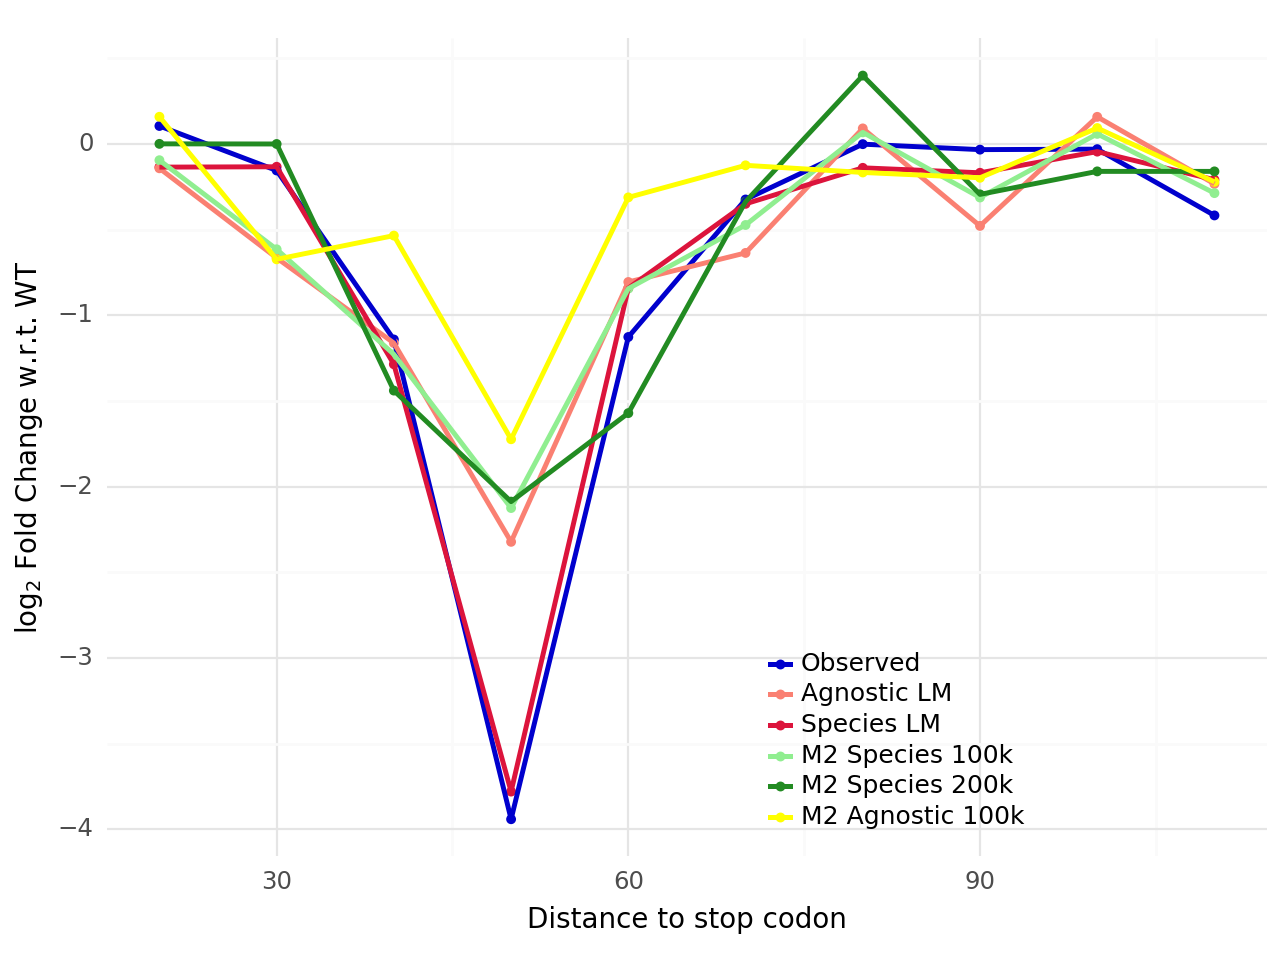

In [14]:
def analyze_fc(bert_adn_preds,gene):
    plot_df = bert_adn_preds.loc[bert_adn_preds["block"].str.contains(gene)]
    wt_expr_true = plot_df.loc[plot_df["Description"].str.contains("Native 3 UTRs")].iloc[0]["true"]
    wt_expr_pred = plot_df.loc[plot_df["Description"].str.contains("Native 3 UTRs")].iloc[0]["pred"]
    wt_expr_pred_agnostic = plot_df.loc[plot_df["Description"].str.contains("Native 3 UTRs")].iloc[0]["pred_agnostic"]
    
    wt_expr_pred_m2_species100k = plot_df.loc[plot_df["Description"].str.contains("Native 3 UTRs")].iloc[0]["pred_m2_species100k"]
    wt_expr_pred_m2_species200k = plot_df.loc[plot_df["Description"].str.contains("Native 3 UTRs")].iloc[0]["pred_m2_species200k"]
    wt_expr_pred_m2_agnostic = plot_df.loc[plot_df["Description"].str.contains("Native 3 UTRs")].iloc[0]["pred_m2_agnostic"]
    
    plot_df = plot_df.loc[plot_df["Description"].str.contains("Scanning mutagenesis")]
    assert len(set(plot_df["block"])) == 1
    plot_df["dist"] = plot_df["Description"].apply(lambda x: int(x.split("#")[2].split("=")[-1]))
    plot_df["dist"] = 140 - plot_df["dist"]
    plot_df["logfc_true"] = plot_df["true"] - wt_expr_true#np.log2(plot_df["true"]/wt_expr_true)
    plot_df["logfc_pred"] = plot_df["pred"] - wt_expr_pred#np.log2(plot_df["pred"]/wt_expr_pred)
    plot_df["logfc_pred_agnostic"] = plot_df["pred_agnostic"] - wt_expr_pred_agnostic#np.log2(plot_df["pred_agnostic"]/wt_expr_pred_agnostic)

    plot_df["logfc_pred_m2_species100k"] = plot_df["pred_m2_species100k"] - wt_expr_pred_m2_species100k#np.log2(plot_df["pred_agnostic"]/wt_expr_pred_agnostic)
    plot_df["logfc_pred_m2_species200k"] = plot_df["pred_m2_species200k"] - wt_expr_pred_m2_species200k#np.log2(plot_df["pred_agnostic"]/wt_expr_pred_agnostic)
    plot_df["logfc_pred_m2_agnostic"] = plot_df["pred_m2_agnostic"] - wt_expr_pred_m2_agnostic#np.log2(plot_df["pred_agnostic"]/wt_expr_pred_agnostic)


    # set impossible fold changes to zero
    #plot_df["logfc_pred"] = plot_df["logfc_pred"].fillna(0)
    #plot_df["logfc_pred_agnostic"] = plot_df["logfc_pred_agnostic"].fillna(0)

    plot_df = (plot_df[["dist","logfc_pred","logfc_true","logfc_pred_agnostic", "logfc_pred_m2_species100k", "logfc_pred_m2_species200k", "logfc_pred_m2_agnostic"]]
               .rename(columns={"logfc_pred":"Species LM",
                                "logfc_pred_agnostic":"Agnostic LM",
                                "logfc_true":"Observed",
                                "logfc_pred_m2_species100k": "M2 Species 100k",
                                "logfc_pred_m2_species200k": "M2 Species 200k",
                                "logfc_pred_m2_agnostic": "M2 Agnostic 100k",
                               })
               .groupby('dist').mean().reset_index().melt("dist"))
    plot_df["variable"] = pd.Categorical(plot_df["variable"], ordered=True, categories=['Observed',"Agnostic LM", 'Species LM', "M2 Species 100k", "M2 Species 200k", "M2 Agnostic 100k"])

    p = (p9.ggplot(data=plot_df, mapping=p9.aes(x="dist",y="value",color="variable",group="variable")) 
     + p9.geom_point(size = 1) 
     + p9.geom_line(size = 1)
     + p9.scale_color_manual(values=["mediumblue","salmon","crimson", "lightgreen", "forestgreen", "yellow"])
    + p9.theme_minimal()
         +p9.theme(axis_title=p9.element_text(size=10),legend_position = (0.70,0.248), legend_direction="vertical", legend_background=p9.element_blank(), legend_key_size=9,
            legend_title=p9.element_text(size=9),legend_text = p9.element_text(size=9),
             )
     #+ p9.geom_smooth(method="lm")
     + p9.labs(x="Distance to stop codon",y="log$_2$ Fold Change w.r.t. WT",color="")
    )
    return plot_df, p
plot_df, p = analyze_fc(bert_adn_preds, "YDR131C")
print (p)
#p.save("Downstream/Graphics/Paper/Downstream_Segal_FC_YDR131C.svg", width=3, height=2.5)


In [15]:
#%%capture
scanned_genes = set([x.split("#")[1].split("context_native_")[-1] for x in bert_adn_preds.loc[bert_adn_preds["Description"].str.contains("Scanning mutagenesis")]["Description"]])
plot_df_list = []
for gene in scanned_genes:
    try:
        plot_df = analyze_fc(bert_adn_preds, gene)[0]
        plot_df["gene"] = gene
        plot_df_list.append(plot_df)
    except IndexError:
        # genes where we have no wt
        #print(gene)
        continue

In [16]:
plot_df = pd.concat(plot_df_list)

In [19]:
plot_df

,dist,variable,value,gene
0,20,Species LM,-0.257372,YAL039C
1,30,Species LM,-0.758955,YAL039C
2,40,Species LM,-2.944267,YAL039C
3,50,Species LM,-1.493356,YAL039C
4,60,Species LM,-0.517365,YAL039C
...,...,...,...,...
55,70,M2 Agnostic 100k,-0.785968,YCR044C
56,80,M2 Agnostic 100k,-0.381735,YCR044C
57,90,M2 Agnostic 100k,-0.765283,YCR044C
58,100,M2 Agnostic 100k,0.291252,YCR044C


In [23]:
plot_observed = plot_df[plot_df["variable"] == "Observed"]
plot_models = plot_df[plot_df["variable"] != "Observed"]
merged = plot_observed.join(plot_models, on=["dist", "gene"], how="inner")

ValueError: len(left_on) must equal the number of levels in the index of "right"

In [46]:
plot_df_full = pd.concat([plot_df.query('variable != "Observed"')[["gene","value"]].rename(columns={"value":"pred"}).reset_index(drop=True), 
                          plot_df.query('variable == "Observed"')[["value"]].rename(columns={"value":"obs"}).reset_index(drop=True)],axis=1)

p = (p9.ggplot(data=plot_df_full, mapping=p9.aes(x="pred",y="obs")) 
 #+ p9.geom_point(size=1,alpha=0.15)
 + p9.geom_point(size=2,alpha=0.1)
 + p9.geom_smooth(method="lm")
 + p9.theme_minimal()
 + p9.facet_grid("variable ~ .")
 + p9.labs(x="Predicted log2 FC (Species)",y="Observed log2 FC")
)
p

PlotnineError: 'At least one layer must contain all variables used for facetting'

# Yeast Expression (Zrimec)

In [24]:
downstream_path_list = dataset_and_model_map["scer"]
upstream_path_list = {} # dataset_and_model_map["scer_upstream"]

In [25]:
expr_df = pd.read_csv("./data/Downstream_Targets/scerevisiae_tpm_full_cut5.csv").query('TPM >= 5')

# apply box-cox transform with lambda = 0.22
expr_df["boxcox_TPM"] = scipy.stats.boxcox(expr_df["TPM"], lmbda=0.22)
# regress out gene length
gene_lengths = np.array(expr_df["gene_len"]).reshape(-1, 1)
expr_df["residual_boxcox_TPM"] = expr_df["boxcox_TPM"] - sklearn.linear_model.LinearRegression().fit(y=expr_df["boxcox_TPM"], X=gene_lengths).predict(X=gene_lengths)

# take median over samples
expr_df = expr_df.groupby('gene_id')[["residual_boxcox_TPM","boxcox_TPM","TPM"]].median().reset_index()
expr_df["log_TPM"] = np.log10(expr_df["TPM"] + 1)

# get test genes
test_genes = pd.read_csv("./data/Downstream_Targets/test_gene_ids.csv")
test_genes_set = set(test_genes["names_test"])
expr_df["is_test"] = expr_df["gene_id"].isin(test_genes_set)

five_sequences = pd.read_parquet("./data/Sequences/Annotation/Sequences/saccharomyces_cerevisiae/saccharomyces_cerevisiae_five_prime.parquet")
cds_sequences = pd.read_parquet("./data/Sequences/Annotation/Sequences/saccharomyces_cerevisiae/saccharomyces_cerevisiae_cds.parquet")
three_sequences = pd.read_parquet("./data/Sequences/Annotation/Sequences/saccharomyces_cerevisiae/saccharomyces_cerevisiae_three_prime.parquet")

In [29]:
three_prime_emb_dict, five_prime_emb_dict = {},{} 

for path in downstream_path_list:
    tmp = np.load(f"{project_path}/{path}/embeddings.npy")            
    three_prime_emb_dict["Downstream: " + get_model_name(path)] = [tmp[i] for i in range(tmp.shape[0])]
    three_sequences["Downstream: " + get_model_name(path)] = [tmp[i] for i in range(tmp.shape[0])]
three_sequences.drop_duplicates(subset=['gene_id'], keep='first', inplace=True)
    
for path in upstream_path_list:
    print (path)
    tmp = np.load(f"{project_path}/{path}/embeddings.npy")            
    five_prime_emb_dict["Upstream: " + get_model_name(path)] = [tmp[i] for i in range(tmp.shape[0])]
    five_sequences["Upstream: " + get_model_name(path)] = [tmp[i] for i in range(tmp.shape[0])]
five_sequences.drop_duplicates(subset=['gene_id'], keep='first', inplace=True)
expr_merged = expr_df.merge(five_sequences, on="gene_id").merge(cds_sequences, on="gene_id").merge(three_sequences, on="gene_id")
y_obs = np.array(expr_merged["residual_boxcox_TPM"])
X_models = {}
for model in three_prime_emb_dict.keys():
    X_models[model] = np.stack(expr_merged[model])
for model in five_prime_emb_dict.keys():
    print (model)
    five_prime_model = np.stack(expr_merged[model])
    X_models[model] = five_prime_model
    if "Aware" in model:
        print (model)
        X_models[f"Combined: Downstream: Aware:candida glabrata ! {model}"] = np.concatenate([five_prime_model, np.stack(expr_merged["Downstream: Aware:candida glabrata"])],axis=1)
    else:
        X_models[f"Combined: Downstream: Agnostic ! {model}"] = np.concatenate([five_prime_model, np.stack(expr_merged["Downstream: Agnostic"])],axis=1)
    #for model_three in three_prime_emb_dict.keys():
    #    X_models[f"Combined: {model_three} ! {model}"] = np.concatenate([X_base, five_prime_model, np.stack(expr_merged[model_three])],axis=1)


vanilla_species_candidatoken
vanilla_species_candidatoken
vanilla_agnostic
vanilla_agnostic
m2_agnostic
m2_agnostic
m2_species100k
m2_species100k
m2_species200k
m2_species200k


In [30]:
#X_base = np.zeros((y_obs.shape[0],1))
X_3mer_five = np.stack(expr_merged['five_prime_seq'].apply(lambda x: kmerizer3.kmerize(x)))
X_4mer_five = np.stack(expr_merged['five_prime_seq'].apply(lambda x: kmerizer4.kmerize(x)))
X_5mer_five = np.stack(expr_merged['five_prime_seq'].apply(lambda x: kmerizer5.kmerize(x)))

X_3mer_three = np.stack(expr_merged['three_prime_seq'].apply(lambda x: kmerizer3.kmerize(x)))
X_4mer_three = np.stack(expr_merged['three_prime_seq'].apply(lambda x: kmerizer4.kmerize(x)))
X_5mer_three = np.stack(expr_merged['three_prime_seq'].apply(lambda x: kmerizer5.kmerize(x)))

X_3mer_combined = np.concatenate([X_3mer_five, X_3mer_three],axis=1)
X_4mer_combined = np.concatenate([X_4mer_five, X_4mer_three],axis=1)
X_5mer_combined = np.concatenate([X_5mer_five, X_5mer_three],axis=1)

data_matrices = {
                 "3-mer-fiveprime":X_3mer_five, 
                 "4-mer-fiveprime":X_4mer_five,
                 "5-mer-fiveprime":X_5mer_five, 
                 "3-mer-threeprime":X_3mer_three,
                 "4-mer-threeprime":X_4mer_three,
                 "5-mer-threeprime":X_5mer_three,
                 "3-mer-combined":X_3mer_combined,
                 "4-mer-combined":X_4mer_combined,
                 "5-mer-combined":X_5mer_combined,
}
data_matrices.update(X_models)

In [31]:
rows = []
df_list = []
total_len = y_obs.shape[0]
test_indices = np.array(expr_merged["is_test"])#.astype(int)
np.random.seed(42)

trained_models = {}

for key in data_matrices:
    print(key)
    y = y_obs
    X = data_matrices[key]
    pipe = pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.linear_model.RidgeCV(cv=5,alphas=[10,100,1000])) 
    pipe.fit(X[~test_indices],y[~test_indices])
    trained_models[key] = pipe
    y_pred = pipe.predict(X[test_indices])
    r2_val = pearson_r2_metric(y_obs[test_indices], y_pred)
    rows.append({"model":key, "r2":r2_val})
    df_list.append(pd.DataFrame({"model":key,"y_pred":y_pred,"y_true":y_obs[test_indices]}))
        
metrics_expr = pd.DataFrame(rows)
preds_expr = pd.concat(df_list)

3-mer-fiveprime
4-mer-fiveprime
5-mer-fiveprime
3-mer-threeprime
4-mer-threeprime
5-mer-threeprime
3-mer-combined
4-mer-combined
5-mer-combined
Downstream: vanilla_species_candidatoken
Downstream: vanilla_agnostic
Downstream: m2_agnostic
Downstream: m2_species100k
Downstream: m2_species200k


In [32]:
metrics_expr

,model,r2
0,3-mer-fiveprime,0.055139
1,4-mer-fiveprime,0.075567
2,5-mer-fiveprime,0.079634
3,3-mer-threeprime,0.045927
4,4-mer-threeprime,0.040213
5,5-mer-threeprime,0.016925
6,3-mer-combined,0.078568
7,4-mer-combined,0.094468
8,5-mer-combined,0.073245
9,Downstream: vanilla_species_candidatoken,0.296932


In [56]:
tmp_data_matrices= dict()
for key in data_matrices.keys():
    tmp_data_matrices[key] = (data_matrices[key],trained_models[key][1].alpha_)
data_matrices = tmp_data_matrices

In [90]:
#The boots trap

rows = []
df_list = []
total_len = y_obs.shape[0]
test_indices = np.array(expr_merged["is_test"])#.astype(int)
np.random.seed(42)

train_indices = np.arange(len(test_indices))[~test_indices]
bootstrapped_models = collections.defaultdict(list)

for key in data_matrices:
    print(key)
    if not "Downstream" in key or "6-mer" in key:
        continue
    y = y_obs
    X, alpha = data_matrices[key]
    for i in tqdm.tqdm(range(100)):
        smpl_indices = np.random.choice(train_indices, size=len(train_indices))
        pipe = pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.linear_model.Ridge(alpha=alpha))
        pipe.fit(X[smpl_indices],y[smpl_indices])
        y_pred = pipe.predict(X[test_indices])
        r2_val = pearson_r2_metric(y_obs[test_indices], y_pred)
        rows.append({"model":key, "r2":r2_val})
        bootstrapped_models[key].append(pipe)

metrics_expr_bootstrap = pd.DataFrame(rows)

metrics_expr_bootstrap.groupby('model').std() * 2

3-mer-fiveprime
4-mer-fiveprime
5-mer-fiveprime
3-mer-threeprime
4-mer-threeprime
5-mer-threeprime
3-mer-combined
4-mer-combined
5-mer-combined
Downstream: Agnostic


 69%|██████▉   | 69/100 [00:03<00:01, 20.35it/s]


KeyboardInterrupt: 

In [91]:
metrics_expr_bootstrap.groupby('model').std().sort_values("r2") * 2

NameError: name 'metrics_expr_bootstrap' is not defined

# Yamanishi

In [94]:
def yamanishi_mpra(path_list, trained_models):
    yamanishi = pd.read_csv("./data/Downstream_Targets/yamanishi_terminator.tsv",sep="\t")#["Sequence of amplified region"].str.len().describe()
    zrimec_preds = pd.read_csv("./data/Downstream_Targets/df_Yamanishi2013_predictions.csv")
    yamanishi_emb_dict = {} 
    for path in path_list:
        tmp = np.load(f"{project_path}/{path}/embeddings.npy")            
        yamanishi_emb_dict[get_model_name(path)] =  np.array([tmp[i] for i in range(tmp.shape[0])])
    for model_name, emb in yamanishi_emb_dict.items():
        print (model_name, emb.shape)
        yamanishi[model_name] = [emb[i] for i in range(emb.shape[0])]
    yamanishi = yamanishi.merge(zrimec_preds, left_on = "Systematic Name", right_on = "gene_name")
    y_obs = np.array(yamanishi["relative FI"])
    X_base = np.zeros((len(y_obs),768))    
    X_models = {}
    data_matrices = {}
    for model in yamanishi_emb_dict.keys():
        if 'Nucleotide' in model:
            X_models[model] = np.concatenate([np.zeros((len(y_obs), 2560)), np.stack(yamanishi[model],axis=0)],axis=1)
        else:
            try:
                X_models[model] = np.concatenate([X_base, np.stack(yamanishi[model],axis=0)],axis=1)

            except:
                print ("could not stack base",model)
        try:
            data_matrices[model] = X_models[model],trained_models[f"Combined: Downstream: {model} ! Upstream: Agnostic"]
            continue
        except:
            pass
        try:
            data_matrices[model] = X_models[model],trained_models[f"Combined: Downstream: {model} ! Upstream: Aware:kazachstania africana"]
        except:
            print ("No matching combined model for:",model)
    rows = []
    dataset = yamanishi
    seq_col = "Sequence of amplified region"
    dataset[seq_col] = "TAA" + dataset[seq_col]
    dataset[seq_col] = dataset[seq_col].str[:300] # 509        
    X_3mer_three = np.stack(dataset[seq_col].apply(lambda x: kmerizer3.kmerize(x)))
    X_4mer_three = np.stack(dataset[seq_col].apply(lambda x: kmerizer4.kmerize(x)))
    X_5mer_three = np.stack(dataset[seq_col].apply(lambda x: kmerizer5.kmerize(x)))
    #X_6mer_three = np.concatenate([X_base, np.stack(dataset[seq_col].apply(lambda x: kmerizer6.kmerize(x)))],axis=1)
    X_3mer_combined = np.concatenate([np.zeros(X_3mer_three.shape), X_3mer_three],axis=1)
    X_4mer_combined = np.concatenate([np.zeros(X_4mer_three.shape), X_4mer_three],axis=1)
    X_5mer_combined = np.concatenate([np.zeros(X_5mer_three.shape), X_5mer_three],axis=1)
    data_matrices["3-mer" ] = X_3mer_combined,trained_models['3-mer-combined']
    data_matrices["4-mer" ] = X_4mer_combined,trained_models['4-mer-combined']
    data_matrices["5-mer" ] = X_5mer_combined,trained_models['5-mer-combined']

    for key in data_matrices:
        print (key)
        X = data_matrices[key][0]
        print (X.shape)
        pipe = data_matrices[key][1]
        y_pred = pipe.predict(X)
        r2_val = pearson_r2_metric(y_obs, y_pred)
        rows.append({"model":key, "r2":r2_val})    
    rows.append({"model":"zrimec","r2":pearson_r2_metric(y_obs, yamanishi["ypred_tdh3"])})
    return pd.DataFrame(rows)

        

In [97]:
metrics_yamanishi = yamanishi_mpra(dataset_and_model_map["yamanishi"], trained_models)
metrics_yamanishi

Agnostic embedding-downstream_300-static_agnostic-yamanishi-512_withstop_bertstyle
Aware:candida glabrata embedding-species_downstream_300-static_candida_glabrata-yamanishi-512_withstop_bertstyle
Agnostic (5302, 768)
Aware:candida glabrata (5302, 768)
Agnostic
(4005, 1536)
Aware:candida glabrata
(4005, 1536)
3-mer
(4005, 128)
4-mer
(4005, 512)
5-mer
(4005, 2048)


,model,r2
0,Agnostic,0.070537
1,Aware:candida glabrata,0.107829
2,3-mer,0.019974
3,4-mer,0.029193
4,5-mer,0.024310
5,zrimec,0.099132


# Segal Promoter MPRA

In [100]:
def segal_promoter_mpra(path_list, trained_models):
    test_predictions = []
    segal_seq = pd.read_csv("./data/Downstream_Targets/segal_sequences.tsv",sep="\t")
    segal_expr = pd.read_csv("./data/Downstream_Targets/segal_expression.tsv",sep="\t")
    zrimec_preds = pd.read_csv("./data/Downstream_Targets/df_Keren2013_predictions.csv")
    # five prime, no species
    segal_emb_dict = dict()
    for path in path_list:
        tmp = np.load(f"{project_path}/{path}/embeddings.npy")  
        segal_emb_dict[get_model_name(path)] = [tmp[i] for i in range(tmp.shape[0])]
        
    for model_name, emb in segal_emb_dict.items():
        segal_seq[model_name] = emb
    segal_5prime_df = segal_seq.merge(segal_expr, on="ORF")
    segal_5prime_df = segal_5prime_df.query('Seq != "NoSeq"')
    segal_5prime_df = segal_5prime_df.loc[~segal_5prime_df.Seq.str.contains(":")]
    
    segal_5prime_zrimec = segal_5prime_df.merge(zrimec_preds[["ORF","ypred"]],on="ORF")
    y_obs = np.array(segal_5prime_zrimec[['Glucose', 'Fructose', 'Sorbitol 1M', 'Growth at 39o',
       'NaCl 1M', 'Glucose lacking amino acids',
       'Galactose lacking amino acids', 'Galactose', 'Glycerol', 'Ethanol']].mean(axis=1))
    X_models = {}
    for model_name in segal_emb_dict.keys():    
        X_models[model_name] = np.stack(segal_5prime_zrimec[model_name],axis=0)
        X_models[model_name] = np.concatenate([X_models[model_name], np.zeros(X_models[model_name].shape)],axis=1)
    data_matrices = {}
    for model in X_models.keys():
        try:
            data_matrices[f"Combined: Downstream: {model} ! Upstream: Agnostic"] = X_models[model],trained_models[f"Combined: Downstream: {model} ! Upstream: Agnostic"]
            continue
        except:
            pass
        try:
            data_matrices[f"Combined: Downstream: Aware:candida glabrata ! Upstream: {model}"] = X_models[model],trained_models[f"Combined: Downstream: Aware:candida glabrata ! Upstream: {model}"]
        except:
            print ("No matching combined model for:",model)

    dataset = segal_5prime_zrimec
    #return dataset, y_obs
    seq_col = "Seq"
    X_3mer_five = np.stack(dataset[seq_col].apply(lambda x: kmerizer3.kmerize(x)))
    X_4mer_five = np.stack(dataset[seq_col].apply(lambda x: kmerizer4.kmerize(x)))
    X_5mer_five = np.stack(dataset[seq_col].apply(lambda x: kmerizer5.kmerize(x)))
    #X_6mer_five = np.concatenate([X_base, np.stack(dataset[seq_col].apply(lambda x: kmerizer6.kmerize(x)))],axis=1)
    print(X_3mer_five.shape)
    X_3mer_combined = np.concatenate([X_3mer_five,np.zeros(X_3mer_five.shape)],axis=1)
    X_4mer_combined = np.concatenate([X_4mer_five, np.zeros(X_4mer_five.shape)],axis=1)
    X_5mer_combined = np.concatenate([X_5mer_five,np.zeros(X_5mer_five.shape)],axis=1)
    data_matrices["3-mer" ] = X_3mer_combined,trained_models['3-mer-combined']
    data_matrices["4-mer" ] = X_4mer_combined,trained_models['4-mer-combined']
    data_matrices["5-mer" ] = X_5mer_combined,trained_models['5-mer-combined']
    
    
    rows = []
    for key in data_matrices:
        X = data_matrices[key][0]
        pipe = data_matrices[key][1]
        y_pred = pipe.predict(X)
        r2_val = pearson_r2_metric(y_obs, y_pred)
        rows.append({"model":key, "r2":r2_val})
        test_predictions.append(pd.DataFrame({"model":key,
                                 "pred": y_pred, 
                                 "true": y_obs}))
    
    rows.append({"model":"zrimec","r2":pearson_r2_metric(y_obs, segal_5prime_zrimec["ypred"])})
    test_predictions.append(pd.DataFrame({"model":'zrimec',
                                 "pred": segal_5prime_zrimec["ypred"], 
                                 "true": y_obs}))
    pred_micro_scer = pd.concat(test_predictions)
    pred_micro_scer["residual"] = (pred_micro_scer["true"] - pred_micro_scer["pred"])**2
    return pd.DataFrame(rows),pred_micro_scer


In [101]:
segal_promoter_mpra_metrics, pred_micro_scer = segal_promoter_mpra(dataset_and_model_map["segal_5prime"], trained_models)

Aware:kazachstania africana embedding-species_upstream_1000-static_kazachstania_africana_cbs_2517_gca_000304475-segal_5prime-1024_withoutstop_bertstyle
Agnostic embedding-upstream_1000-static_agnostic-segal_5prime-1024_withoutstop_bertstyle
(621, 64)


In [102]:
segal_promoter_mpra_metrics

,model,r2
0,Combined: Downstream: Aware:candida glabrata !...,0.453971
1,Combined: Downstream: Agnostic ! Upstream: Agn...,0.351996
2,3-mer,0.006833
3,4-mer,0.061807
4,5-mer,0.230468
5,zrimec,0.440276


In [103]:
scipy.stats.wilcoxon(pred_micro_scer.query('model == "Combined: Downstream: Aware:candida glabrata ! Upstream: Aware:kazachstania africana"')["residual"], pred_micro_scer.query('model == "zrimec"')["residual"])


WilcoxonResult(statistic=0.0, pvalue=2.233932560757222e-103)

# Predict for diauxic shift Microarray data

In [10]:
microarray_all = pd.read_csv("./data/Downstream_Targets/Microarray_raw_dedup.csv")

In [11]:
organisms = ['candida_albicans_sc5314_gca_000784635', 'candida_glabrata', 'debaryomyces_hansenii_cbs767_gca_000006445',
 'kluyveromyces_lactis_gca_000002515', 'schizosaccharomyces_japonicus', "schizosaccharomyces_pombe",
 'vanderwaltozyma_polyspora_dsm_70294_gca_000150035', 'yarrowia_lipolytica', 'saccharomyces_cerevisiae']

In [12]:
five_sequences_all = pd.read_parquet("./data/Sequences/Annotation/Assembled/five_prime.parquet")
five_sequences_all = five_sequences_all.query('organism in @organisms')
five_sequences_all = five_sequences_all.loc[five_sequences_all["five_prime_seq"].str.len() == 1003]

In [13]:
emb_fiveprime = np.load(project_path+"embedding-upstream_1000-static_agnostic-microarray-1024_withoutstop_bertstyle/embeddings.npy")
emb_fiveprime = [emb_fiveprime[i] for i in range(emb_fiveprime.shape[0])]
five_sequences_all["five_prime_embedding"] = emb_fiveprime

emb_fiveprime_species = np.load(project_path+"embedding-species_upstream_1000-static_many_species-microarray-1024_withoutstop_bertstyle/embeddings.npy")
emb_fiveprime_species = [emb_fiveprime_species[i] for i in range(emb_fiveprime_species.shape[0])]
five_sequences_all["five_prime_embedding_species"] = emb_fiveprime_species


In [14]:
organisms_threeprime = ['candida_albicans_sc5314_gca_000784635', 'candida_glabrata', 'debaryomyces_hansenii_cbs767_gca_000006445',
                 'kluyveromyces_lactis_gca_000002515',
                 'vanderwaltozyma_polyspora_dsm_70294_gca_000150035', 'yarrowia_lipolytica']

three_sequences_all = pd.read_parquet("./data/Sequences/Annotation/Assembled/three_prime.parquet")
three_sequences_all = three_sequences_all.query('organism in @organisms_threeprime')
three_sequences_all["three_prime_seq"] = three_sequences_all["three_prime_seq"].str[:300]
three_sequences_all = three_sequences_all.loc[three_sequences_all["three_prime_seq"].str.len() == 300]

In [15]:
emb_threeprime = np.load(project_path+"embedding-downstream_300-static_agnostic-microarray_downstream-512_withstop_bertstyle/embeddings.npy")
emb_threeprime = [emb_threeprime[i] for i in range(emb_threeprime.shape[0])]
three_sequences_all["three_prime_embedding"] = emb_threeprime

emb_threeprime_species = np.load(project_path+"embedding-species_downstream_300-static_many_species-microarray_downstream-512_withstop_bertstyle/embeddings.npy")
emb_threeprime_species = [emb_threeprime_species[i] for i in range(emb_threeprime_species.shape[0])]
three_sequences_all["three_prime_embedding_species"] = emb_threeprime_species

In [16]:
five_sequences_all

,gene_id,transcript_id,Chromosome,Feature,Start,End,Strand,five_prime_start,five_prime_end,five_prime_seq,organism,species,five_prime_embedding,five_prime_embedding_species
3435471,W5Q_00575,KHC83359,supercont4.1,start_codon,1234961,1234964,+,1233961,1234964,CCTCGTTTGAAATGGTAGTTTTGAAATAGGGTTTGTATCCAACAGG...,candida_albicans_sc5314_gca_000784635,candida_albicans,"[0.068653494, 0.015206551, -0.021652974, -0.16...","[0.06493876, -0.100349575, 0.018514436, 0.0325..."
3435472,W5Q_00675,KHC83458,supercont4.1,start_codon,1488618,1488621,+,1487618,1488621,ACCAGTATGTAAGGAGATGATGCTAACAGAGGATTCAGTTTTGGTG...,candida_albicans_sc5314_gca_000784635,candida_albicans,"[0.036147296, 0.025376495, -0.0061738696, -0.0...","[0.0545368, 0.119643144, -0.0065993257, 0.0437..."
3435473,W5Q_00708,KHC83490,supercont4.1,start_codon,1564846,1564849,+,1563846,1564849,AATTTTGACATTCAATATACCAGGACTGACTATACAATTGATTTCA...,candida_albicans_sc5314_gca_000784635,candida_albicans,"[-0.15883088, -0.021592634, 0.030859975, -0.54...","[0.01612491, 0.086933665, -0.031225346, 0.0250..."
3435474,W5Q_01237,KHC84013,supercont4.1,start_codon,2807108,2807111,+,2806108,2807111,ACAATTATTTGGTGATGATAATGGAGAATTTAATTTAAGTGAAATA...,candida_albicans_sc5314_gca_000784635,candida_albicans,"[-0.089624725, 0.02925052, -0.014624437, -0.90...","[0.077558234, 0.3897506, -0.015687384, 0.03565..."
3435475,W5Q_00536,KHC83323,supercont4.1,start_codon,1156335,1156338,+,1155335,1156338,AATGATTTAGTACCATTTTCGATACTCTTTTTCCCACTTTCAGTAG...,candida_albicans_sc5314_gca_000784635,candida_albicans,"[-0.073895775, 0.055318058, -0.003053937, -0.7...","[0.02883135, -0.09521633, -0.027411956, 0.0001..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14677878,YALI0_F18040g,CAG78370,F,start_codon,2404344,2404347,-,2404344,2405347,TATTGTAGTGGGAGACCATACGAGAATCCTGGGTGCTGTAATCTTT...,yarrowia_lipolytica,yarrowia_lipolytica,"[-0.3018363, -0.005869295, 0.022159437, -0.244...","[0.07424399, 0.12904361, -0.010953401, 0.04557..."
14677881,YALI0_F10923g,CAG78073,F,start_codon,1458078,1458081,-,1458078,1459081,GCCTCTTTCTCGAGTCGATCCGTCCACTGCAACCTCCATGGTCCCT...,yarrowia_lipolytica,yarrowia_lipolytica,"[-0.46078548, -0.08309572, 0.038748596, -0.662...","[0.0104980245, 0.2365075, -0.0038241881, 0.047..."
14677882,YALI0_F06556g,CAG77892,F,start_codon,971905,971908,-,971905,972908,AATCAGACAATAGTACAAGTACAATGGAAGCTGGCCATTGTTGTCT...,yarrowia_lipolytica,yarrowia_lipolytica,"[-0.37120572, -0.0012745588, 0.04519816, -0.07...","[0.10203641, 0.16689563, 0.0025999122, 0.00292..."
14677883,YALI0_F26455g,CAG78720,F,start_codon,3387003,3387006,-,3387003,3388006,ATACGGATCCCGCAATCTCTGGTCATAGTAGGAATGTCGAACGTAC...,yarrowia_lipolytica,yarrowia_lipolytica,"[-0.18022203, -0.038665965, 0.030178862, -0.29...","[0.050544992, 0.04968849, -0.0055678324, 0.034..."


## C. glabrata



In [17]:
microarray_test = microarray_all.reset_index().query('Study == "Thompson_diauxicshift"').query('Organism not in ["Saccharomyces cerevisiae", "Schizosaccharomyces pombe", "Schizosaccharomyces japonicus"]')
microarray_test = (microarray_test
              .merge(five_sequences_all,on="gene_id")
              .merge(three_sequences_all[["gene_id","three_prime_seq","three_prime_embedding","three_prime_embedding_species"]],on="gene_id")
              .dropna())
microarray = microarray_test

In [19]:
microarray = microarray.query("Organism == 'Candida glabrata'")

In [20]:
rows = []
df_list = []
test_predictions = []
np.random.seed(42)
import copy 

pipe_index_dict = dict()

for organism in set(microarray["Organism"]):
    print (organism)
    for condition in set(microarray["Condition"]):
        print(condition)
        micro_df = microarray.query('Condition == @condition and Organism == @organism').reset_index(drop=True)
        if len(micro_df) == 0:
            continue
        y_obs = np.array(micro_df["Expression"])
        # compute features
        X_bert_five = np.stack(micro_df["five_prime_embedding"],axis=0)
        X_bert_five_species = np.stack(micro_df["five_prime_embedding_species"],axis=0)
        X_bert_three = np.stack(micro_df["three_prime_embedding"],axis=0)
        X_bert_three_species = np.stack(micro_df["three_prime_embedding_species"],axis=0)
        X_bert_combined = np.concatenate([X_bert_five,X_bert_three],axis=1)
        X_bert_combined_species = np.concatenate([X_bert_five_species,X_bert_three_species],axis=1)

        X_3mer_five = np.stack(micro_df['five_prime_seq'].apply(lambda x: kmerizer3.kmerize(x)))
        X_4mer_five = np.stack(micro_df['five_prime_seq'].apply(lambda x: kmerizer4.kmerize(x)))
        X_5mer_five = np.stack(micro_df['five_prime_seq'].apply(lambda x: kmerizer5.kmerize(x)))
        #X_6mer_five = np.stack(micro_df['five_prime_seq'].apply(lambda x: kmerizer6.kmerize(x)))
        X_3mer_three = np.stack(micro_df['three_prime_seq'].apply(lambda x: kmerizer3.kmerize(x)))
        X_4mer_three = np.stack(micro_df['three_prime_seq'].apply(lambda x: kmerizer4.kmerize(x)))
        X_5mer_three = np.stack(micro_df['three_prime_seq'].apply(lambda x: kmerizer5.kmerize(x)))
        #X_6mer_three = np.stack(micro_df['three_prime_seq'].apply(lambda x: kmerizer6.kmerize(x)))
        X_3mer_combined = np.concatenate([X_3mer_five, X_3mer_three],axis=1)
        X_4mer_combined = np.concatenate([X_4mer_five, X_4mer_three],axis=1)
        X_5mer_combined = np.concatenate([X_5mer_five, X_5mer_three],axis=1)
        #X_6mer_combined = np.concatenate([X_6mer_five, X_6mer_three],axis=1)

        data_matrices = {"BERT-ADN-threeprime":X_bert_three,
                        "BERT-ADN-threeprime-species":X_bert_three_species,
                        "BERT-ADN-fiveprime":X_bert_five,
                        "BERT-ADN-fiveprime-species":X_bert_five_species,
                        "BERT-ADN-combined":X_bert_combined,
                        "BERT-ADN-combined-species":X_bert_combined_species,
                         "3-mer-fiveprime":X_3mer_five, 
                         "4-mer-fiveprime":X_4mer_five,
                         "5-mer-fiveprime":X_5mer_five, 
                         "3-mer-threeprime":X_3mer_three,
                         "4-mer-threeprime":X_4mer_three,
                         "5-mer-threeprime":X_5mer_three,
                         "3-mer-combined":X_3mer_combined,
                         "4-mer-combined":X_4mer_combined,
                         "5-mer-combined":X_5mer_combined,
        }

        kfold = sklearn.model_selection.KFold(n_splits=10, shuffle=True, random_state=42)

        for key in data_matrices:
            print(key)
            y = y_obs
            X = data_matrices[key]

            y_pred_list = []
            y_true_list = []
            for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
                pipe = pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.linear_model.RidgeCV(cv=3, alphas=[10, 100, 1000]))
                X_train = X[train_index]
                y_train = y[train_index]
                X_test = X[test_index]
                y_test = y[test_index]
                pipe.fit(X_train,y_train)
                y_pred = pipe.predict(X_test)
                r2_test = pearson_r2_metric(y_test, y_pred)
                y_pred_list.append(y_pred)
                y_true_list.append(y_test)
                rows.append({"model":key,
                             "species":organism,
                             "condition":condition,
                             "r2":r2_test})
            test_predictions.append(pd.DataFrame({"model":key,
                                                  "species":organism,
                                                  "condition":condition,
                                     "pred": np.concatenate(y_pred_list), 
                                     "true": np.concatenate(y_true_list)}))
metrics_micro_other = pd.DataFrame(rows)
pred_micro_other = pd.concat(test_predictions)
pred_micro_other["residual"] = (pred_micro_other["true"] - pred_micro_other["pred"])**2

Candida glabrata
PS
BERT-ADN-threeprime
BERT-ADN-threeprime-species
BERT-ADN-fiveprime
BERT-ADN-fiveprime-species
BERT-ADN-combined
BERT-ADN-combined-species
3-mer-fiveprime
4-mer-fiveprime
5-mer-fiveprime
3-mer-threeprime
4-mer-threeprime
5-mer-threeprime
3-mer-combined
4-mer-combined
5-mer-combined
PLAT
BERT-ADN-threeprime
BERT-ADN-threeprime-species
BERT-ADN-fiveprime
BERT-ADN-fiveprime-species
BERT-ADN-combined
BERT-ADN-combined-species
3-mer-fiveprime
4-mer-fiveprime
5-mer-fiveprime
3-mer-threeprime
4-mer-threeprime
5-mer-threeprime
3-mer-combined
4-mer-combined
5-mer-combined
LAG
BERT-ADN-threeprime
BERT-ADN-threeprime-species
BERT-ADN-fiveprime
BERT-ADN-fiveprime-species
BERT-ADN-combined
BERT-ADN-combined-species
3-mer-fiveprime
4-mer-fiveprime
5-mer-fiveprime
3-mer-threeprime
4-mer-threeprime
5-mer-threeprime
3-mer-combined
4-mer-combined
5-mer-combined
ll
BERT-ADN-threeprime
BERT-ADN-threeprime-species
BERT-ADN-fiveprime
BERT-ADN-fiveprime-species
BERT-ADN-combined
BERT-ADN-c

In [21]:
pred_micro_other
scipy.stats.wilcoxon(pred_micro_other.query("species == 'Candida glabrata'").query('model == "BERT-ADN-combined-species"')["residual"], pred_micro_other.query("species == 'Candida glabrata'").query('model == "BERT-ADN-combined"')["residual"])


WilcoxonResult(statistic=150382582.0, pvalue=2.3461313127918796e-26)

In [22]:
for species in pred_micro_other.species.unique():
    sub_micro = pred_micro_other.loc[pred_micro_other.species == species]
    print (species, scipy.stats.wilcoxon(sub_micro.query('model == "BERT-ADN-combined-species"')["residual"], sub_micro.query('model == "BERT-ADN-combined"')["residual"]))
    #print (species, scipy.stats.wilcoxon(sub_micro.query('model == "BERT-ADN-threeprime-species"')["residual"], sub_micro.query('model == "BERT-ADN-threeprime"')["residual"]))
    #print (species, scipy.stats.wilcoxon(sub_micro.query('model == "BERT-ADN-fiveprime-species"')["residual"], sub_micro.query('model == "BERT-ADN-fiveprime"')["residual"]))


Candida glabrata WilcoxonResult(statistic=150382582.0, pvalue=2.3461313127918796e-26)


In [24]:
metrics_micro_other.query("model == 'BERT-ADN-combined-species'").groupby(["species"])[["r2"]].median().tail(60).sort_values('r2')

,r2
species,
Candida glabrata,0.456447


In [26]:
metrics_micro_other.groupby(['model','species',])[["r2"]].median().query("species == 'Candida glabrata'").sort_values("r2")

,,r2
model,species,
5-mer-threeprime,Candida glabrata,0.021593
3-mer-threeprime,Candida glabrata,0.024481
4-mer-threeprime,Candida glabrata,0.025314
BERT-ADN-threeprime,Candida glabrata,0.063825
BERT-ADN-threeprime-species,Candida glabrata,0.066696
3-mer-fiveprime,Candida glabrata,0.107703
3-mer-combined,Candida glabrata,0.123278
4-mer-fiveprime,Candida glabrata,0.154971
4-mer-combined,Candida glabrata,0.162162
